In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [123]:
import fastai.datasets as datasets
import gzip
import pickle
from torch import tensor, nn, optim
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib as mpl
import matplotlib.pyplot as plt

In [50]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [130]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [97]:
x_train,y_train,x_valid,y_valid = get_data()

tensor(5)


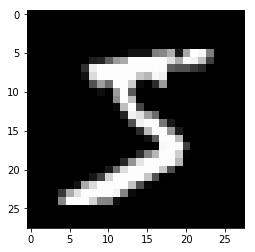

In [183]:
mpl.rcParams['image.cmap'] = 'gray'
img = x_train[0]
plt.imshow(img.view((28,28)))
print(y_train[0])

In [106]:
bs = 32
train_ds, valid_ds = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs*2, shuffle=False)
xb,yb = next(iter(train_dl))

In [83]:
def get_model(inputs, classes, lr=0.5, nh=50):
    model = nn.Sequential(nn.Linear(inputs,nh), nn.ReLU(), nn.Linear(nh,classes))
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt

In [197]:
from torch.utils.tensorboard import SummaryWriter

def fit(epochs, model, opt, loss_func, train_dl, valid_dl):    
    writer = SummaryWriter()

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
        writer.add_scalar("Loss", tot_loss/nv, epoch)
        writer.add_scalar("Accuracy", tot_acc/nv, epoch)

    writer.flush()
    writer.close()

In [198]:
inputs = x_train[0].shape[0]
classes = int(y_train.max() + 1)
model, opt = get_model(inputs, classes, lr=0.1)
epochs = 10
loss_func = F.cross_entropy
fit(epochs, model, opt, loss_func, train_dl, valid_dl)

0 tensor(0.1998) tensor(0.9441)
1 tensor(0.1540) tensor(0.9565)
2 tensor(0.1280) tensor(0.9636)
3 tensor(0.1440) tensor(0.9583)
4 tensor(0.1292) tensor(0.9604)
5 tensor(0.1071) tensor(0.9674)
6 tensor(0.1031) tensor(0.9683)
7 tensor(0.0985) tensor(0.9708)
8 tensor(0.1018) tensor(0.9699)
9 tensor(0.0955) tensor(0.9719)


Actual: tensor(6)
Prediction: tensor([8])
Actual: tensor(8)
Prediction: tensor([1])
Actual: tensor(0)
Prediction: tensor([2])
Actual: tensor(9)
Prediction: tensor([8])
Actual: tensor(5)
Prediction: tensor([8])
Actual: tensor(0)
Prediction: tensor([7])
Actual: tensor(9)
Prediction: tensor([7])


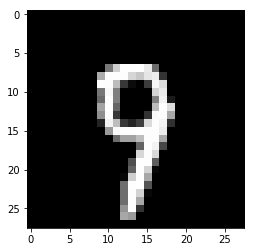

In [186]:
import random
model.eval()

for i in range(100):
    test_i = random.randrange(len(y_valid))
    pred = torch.argmax(model(x_valid[test_i].unsqueeze(0)), dim=1)
    if pred!=y_valid[test_i]:    
        img = x_valid[test_i]
        plt.imshow(img.view((28,28)))
        print("Actual:", y_valid[test_i])
        print("Prediction:", pred)

In [143]:
x_train[test_i].unsqueeze(0).shape

torch.Size([1, 784])

In [201]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [202]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [203]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [204]:
c = y_train.max().item()+1
data = DataBunch(get_dls(train_ds, valid_ds, ))

TypeError: get_dls() missing 1 required positional argument: 'bs'